In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import math
env = gym.make("LunarLander-v2")

C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Understand the environment

In [2]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)
show_action_and_env_space(env)

env.action_space Discrete(4)
env.observation_space Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
env.observation_space.high [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
env.observation_space.low [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


### Try to play with the lunar lander environment


In [3]:
#observation, info = env.reset(seed=42, return_info=True)

#epochs = 0
#for _ in range(1000):
#    observation, reward, done, info = env.step(env.action_space.sample())
#    env.render()
#
#    if done:
#        epochs += 1
#        observation, info = env.reset(return_info=True)
#
#env.close()
#print(epochs)

### Utility functions for SARSA and Q-Learning

In [4]:
# Discretizzazione
n = 5

s_space = np.linspace(-1.5, 1.5, n) # min max n_parti
v_space = np.linspace(5, 5, n)
theta_space = np.linspace(-3.1415927, 3.1415927, n)
omega_space = np.linspace(5, 5, n)

def discretize_states(observation):
    sx, sy, vx, vy, theta, omega, bo1, bo2 = observation
    sx_d = int(np.digitize(sx, s_space))
    sy_d = int(np.digitize(sy, s_space))
    vx_d = int(np.digitize(vx, v_space))
    vy_d = int(np.digitize(vy, v_space))
    theta_d = int(np.digitize(theta, theta_space))
    omega_d = int(np.digitize(omega, omega_space))

    return (sx_d, sy_d, vx_d, vy_d, theta_d, omega_d, bo1, bo2)   

In [5]:
states = []
for sx in range(n+1):
    for sy in range(n+1):
        for vx in range(n+1):
            for vy in range(n+1):
                for theta in range(n+1):
                    for omega in range(n+1):
                        for bo1 in range(2):
                            for bo2 in range(2):
                                states.append((sx, sy, vx, vy, theta, omega, bo1, bo2))
state_number = len(states)

actions = [0,1,2,3]
action_number = len(actions)


In [6]:
def init_Qtable(state_number, action_number):
    q_table = {}
    for state in states:
        for action in actions:
            q_table[state,action] = 0
    return q_table

In [7]:
def choose_action(q_table, s, eps):
    if (np.random.random() <= eps):
        return env.action_space.sample() #Exploration
    else:
        q_action_s = [q_table[s,i] for i in actions] 
        return np.argmax(q_action_s) #Eplotation

In [8]:
min_epsilon = 0.01
max_epsilon = 1.0
episodes = 20
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 - 
                              math.log10((episode + 1) / (episodes*0.1))))

### SARSA

In [12]:
alpha = 0.01
eps = 0.1
gamma = 0.99
steps = 10
episodes = 1000

render = False

def sarsa():
    tot_reward = []
    q_table = init_Qtable(state_number, action_number)
    for ep in range(episodes):
        eps = decay_function(ep)
        tot_ep_reward = 0
        done = False
        s = env.reset() # seed = 42
        s = discretize_states(s)
        a = choose_action(q_table, s, eps)
        i = 0
        while not done:
            s_p, reward, done, _ = env.step(a)
            if render:
                env.render()
            s_p = discretize_states(s_p)
            a_p = choose_action(q_table, s_p, eps)
            q_table[s,a] += alpha*(reward + gamma*q_table[s_p,a_p] - q_table[s,a])
            s, a = s_p, a_p
            tot_ep_reward += reward
            i+=1
        tot_reward.append(tot_ep_reward)
    env.close()
    return tot_reward
        

### Q-Learning

In [15]:
alpha = 0.01
eps = 0.1
gamma = 0.99
steps = 10
episodes = 5000

render = False

def q_learning():
    tot_reward = []
    q_table = init_Qtable(state_number, action_number)
    for ep in range(episodes):
        eps = decay_function(ep)
        tot_ep_reward = 0
        done = False
        s = env.reset() # seed = 42
        s = discretize_states(s)
        i = 0
        while not done:
            a = choose_action(q_table, s, eps)
            s_p, reward, done, _ = env.step(a)
            if render:
                env.render()
            s_p = discretize_states(s_p)
            a_p = choose_action(q_table, s_p, eps)
            q_action_s_p = [q_table[s_p,i] for i in actions] 
            q_table[s_p,a] += alpha*(reward + gamma*(np.argmax(q_action_s_p)) - q_table[s,a])
            s = s_p
            tot_ep_reward += reward
            i+=1
        tot_reward.append(tot_ep_reward)
    env.close()
    return tot_reward

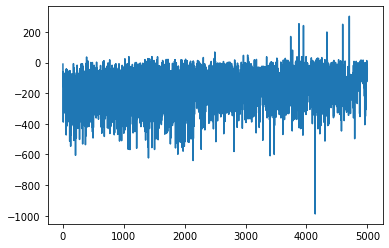

In [16]:
#rew = sarsa()
rew = q_learning()
plt.plot(rew)